In [3]:
from plot import *

In [4]:
from IPython.display import Image,display

In [5]:
import uproot

In [6]:
!ls

CMS_lumi_v2.C
CMS_lumi_v2.h
DQM_V0001_R000000000__HLT__FastTimerService__All.root
DQM_V0001_R000000001__HLT__FastTimerService__All.root
HARVEST.root
Untitled.ipynb
basic_harvest.root
dqm_time_1.root
dqm_time_m1.root
harvest.root
l1_pixel3.root
l1_pixel4.root
l1_pixmask.root
l1_pixmask_DQM.root
l1_pixmask_time.root
l1_recovery.root
m1.root
pix3_l1_recovery.root
pix4_l1_recovery.root
pixel1.root
pixel1trip.root
pixel3_l1.root
pixel4_l1.root
pixel_l1_3.root
plot.py
plot.pyc
pure_l1.root
setTDRStyle.py
setTDRStyle.pyc
step3.root
step3_inDQM.root
step3_inDQM_2.root
step3_inDQM_time_1.root
step3_inDQM_time_m1.root
ttbar_pu35_phase1_efficiency_eta_cum.pdf
ttbar_pu35_phase1_efficiency_eta_cum.png
ttbar_pu35_phase1_efficiency_pt_cum.pdf
ttbar_pu35_phase1_efficiency_pt_cum.png
ttbar_pu35_phase1_efficiency_r_cum.pdf
ttbar_pu35_phase1_efficiency_r_cum.png
v6_1.root


In [7]:
from setTDRStyle import setTDRStyle

In [8]:

class Files:
    def __init__(self, filesLegends):
        self._files = []
        self._legends = []
        self._styles = []
        for fl in filesLegends:
            self._legends.append(fl[1])
            self._styles.append(fl[2])
            if isinstance(fl[0], tuple):
                self._files.append([ROOT.TFile.Open(f) for f in fl[0]])
            else:
                self._files.append(ROOT.TFile.Open(fl[0]))

    def getFiles(self):
        return self._files

    def getHistos(self, name):
        ret = []
        for f in self._files:
            path = "DQMData/Run 1/"+name
            if isinstance(f, list):
                fil = f[0]
                #if "cutsRecoPt" in name:
                #    path = "DQMData/Run 1/"+name.replace("cutsRecoPt", "cutsReco")
                #    fil = f[1]
                obj = fil.Get(path)
            else:
                #if "cutsRecoPt" in name:
                #    path = "DQMData/Run 1/"+name.replace("cutsRecoPt", "cutsReco")
                obj = f.Get(path)
            if not obj:
                raise Exception("Object %s not found from %s" % (path, f.GetPath()))
            ret.append(obj)
        return ret

    def getLegends(self):
        return self._legends

    def getStyles(self):
        return self._styles

def applyStyle(h, color, markerStyle):
    h.SetMarkerStyle(markerStyle)
    h.SetMarkerColor(color)
    h.SetMarkerSize(1.2)
    h.SetLineColor(color)
    h.SetLineWidth(2)

#styles = [
##    lambda h: applyStyle(h, ROOT.kBlack, 34),
##    lambda h: applyStyle(h, ROOT.kBlue, 21),
##    lambda h: applyStyle(h, ROOT.kRed, 22),
##    lambda h: applyStyle(h, ROOT.kGreen, 20),
#    lambda h: applyStyle(h, ROOT.kBlack, 21),
#    lambda h: applyStyle(h, ROOT.kBlue, 20),
#    lambda h: applyStyle(h, ROOT.kRed, 22),
#    lambda h: applyStyle(h, ROOT.kGreen, 34),
#]

class Plot:
    def __init__(self, histos, legends, styles):
        self._histos = histos[:]
        self._legends = legends[:]
        self._styles = styles[:]

    def remove(self, i):
        del self._histos[i]
        del self._legends[i]
        del self._styles[i]

    def histos(self):
        return self._histos

    def setHistos(self, histos):
        if len(self._histos) != len(histos):
            raise Exception("Had %d histograms, was trying to set %d" % (len(self._histos), len(histos)))
        self._histos = histos

    def scale(self, scale):
        for h in self._histos:
            h.Scale(scale)

    def rebin(self, rebin):
        for h in self._histos:
            h.Rebin(rebin)

    def normalizeToUnitArea(self):
        for h in self._histos:
            if h is None:
                continue
            i = h.Integral()
            if i == 0:
                continue
            if h.GetSumw2().fN <= 0: # to suppress warning
                h.Sumw2()
            h.Scale(1.0/i)

    def draw(self, opt=""):
        self._isHist = ("hist" in opt.lower())

        for h, style in zip(self._histos, self._styles):
            style(h)
            if self._isHist:
                h.SetLineWidth(3)

            h.Draw("same"+opt)

    def addToLegend(self, legend, legendColumns):
        st = "LP"
        if self._isHist:
            st = "L"

        for h, label in zip(self._histos, self._legends):
            legend.AddEntry(h, label, st)

    def getXmin(self):
        if len(self._histos) == 0:
            return 0
        return min([h.GetXaxis().GetBinLowEdge(h.GetXaxis().GetFirst()) for h in self._histos])

    def getXmax(self):
        if len(self._histos) == 0:
            return 1
        return max([h.GetXaxis().GetBinUpEdge(h.GetXaxis().GetLast()) for h in self._histos])

    def getYmax(self):
        if len(self._histos) == 0:
            return 1
        return max([h.GetMaximum() for h in self._histos])

class PlotStack:
    def __init__(self):
        self._histos = []
        self._legends = []

#    def add(self, histo, legend):
#        self._histos.append(histo)
#        self._legends.append(legend)
    def add(self, tmphisto, legend):
#        print("adding",histo)
        arr = hist2array(tmphisto)
        nbins = tmphisto.GetNbinsX()
        xmin = tmphisto.GetXaxis().GetXmin()
        xmax = tmphisto.GetXaxis().GetXmax()
        name  = tmphisto.GetName()
        title = tmphisto.GetTitle()
        histo = ROOT.TH1F(name,title,nbins,xmin,xmax)
        array2hist(arr,histo)
        print(tmphisto.GetFillColor())
        histo.SetFillColor(tmphisto.GetFillColor())
        self._histos.append(histo)
        self._legends.append(legend)

    def draw(self, opt=""):
        self._stack = ROOT.THStack()
        for h in self._histos:
            self._stack.Add(h)
        self._stack.Draw("same"+opt)

    def addToLegend(self, legend, legendColumns):
        st = "f"
        for h, label in zip(self._histos, self._legends):
            legend.AddEntry(h, label, st)



In [9]:
setTDRStyle()

ROOT.gROOT.LoadMacro("./CMS_lumi_v2.C")

ROOT.gStyle.SetTitleYOffset(1.0)
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

styleRun2 = lambda h: applyStyle(h, ROOT.kBlue, 21)
styleRun2Realistic = lambda h: applyStyle(h, ROOT.kMagenta, 34)
stylePhase1 = lambda h: applyStyle(h, ROOT.kRed, 20)
stylePhase1PU70 = lambda h: applyStyle(h, ROOT.kBlack, 22)
stylePhase1CA = lambda h: applyStyle(h, ROOT.kBlack, 22)

stylePU0 = lambda h: applyStyle(h, ROOT.kBlue, 21)
stylePU35 = lambda h: applyStyle(h, ROOT.kRed, 20)
stylePU50 = lambda h: applyStyle(h, ROOT.kBlack, 22)
stylePU70 = lambda h: applyStyle(h, ROOT.kOrange+7, 34)

In [17]:

def plotColoredEff(phase1file, prefix, pileup):
    folder_track = "DQMData/Run 1/Tracking/Run summary/Track/hltPhase2CutsReco%s_hltPhase2ingParticleRecoTrackAsssociation/"
    #folder_track = "DQMData/Run 1/Tracking/Run summary/Track/hltPhase2CutsReco%sHp_trackingParticleRecoAsssociation/"
    #folder_track = "DQMData/Run 1/Tracking/Run summary/Track/hltPhase2CutsReco%sByOriginalAlgo_hltPhase2ingParticleRecoTrackAsssociation/"
    iterations = [
        "L1Step",
        "InitialStep",
        
        #"HighPtTripletStep"
    ]
    legendLabels = [x.replace("Step", "").replace("Regional", "").replace("SeededInOut", " inside-out").replace("SeededOutIn", " outside-in") for x in iterations]
    legendLabels[1:] = ["+"+x for x in legendLabels[1:]]

    putext = ""
    if pileup is not None:
        putext = " (%s)" % pileup

    xmin = 0.33
    xmax = 0.87
    legendDw = 0
    effbox = PlotTextBox(xmin, None, xmax, 0.31, transparent=True)
    effbox.addText("t#bar{t} event tracks%s"%putext)
    effbox.addText("p_{T} > 0.9 GeV, |#eta| < 2.5, ^{}d_{0} < 3.5 cm")

    # pt
    effbox_pt = effbox.clone()
    effbox_pt.replaceText(1, "|#eta| < 2.5, ^{}d_{0} < 3.5 cm")
    effbox_pt.move(dx=0.06, dy=-0.02)
#    effbox_pt.move(dx=-0.13, dy=0.6)
    plot = PlotStack()
    for it, leg in zip(iterations, legendLabels):
        hname = folder_track%it + "efficPt"
        #print(hname)
        h = phase1file.Get(hname)
        if not h:
            raise Exception("Did not find %s from %s" % (hname, phase1file.GetName()))
        h.SetFillColor(iter_colors[it])
        h.SetLineColor(ROOT.kBlack)
        plot.add(h, leg)
    _common = {
        "xtitle": "Simulated track p_{T} (GeV)",
        "xmin": 1e-1, "xmax": 2e2, "ymin": 0, "ymax": 1,
        "xlog": True,
        "legendDx": -0.13, "legendDy": -0.24, "legendDw": legendDw, "legendDh": 0.23,
        "legendTransparent": True,
        "customise": lambda: effbox_pt.Draw(),
        "drawOpt": "HIST",
    }
    drawPlot(prefix+"_efficiency_pt_cum", plot, ytitle="Tracking efficiency", **_common)
    

    # eta
    effbox_eta = effbox.clone()
    effbox_eta.replaceText(1, "p_{T} > 0.9 GeV, ^{}d_{0} < 3.5 cm")
    effbox_eta.move(dx=0.06, dy=-0.02)
#    effbox_pt.move(dx=-0.13, dy=0.6)
    plot = PlotStack()
    for it, leg in zip(iterations, legendLabels):
        hname = folder_track%it + "effic"
        h = phase1file.Get(hname)
        if not h:
            raise Exception("Did not find %s from %s" % (hname, phase1file.GetName()))
        h.SetFillColor(iter_colors[it])
        h.SetLineColor(ROOT.kBlack)
        plot.add(h, leg)
    _common = {
        "xtitle": "Simulated track #eta",
        "xmin": -3, "xmax": 3, "ymin": 0, "ymax": 1,
        "legendDx": -0.15, "legendDy": -0.24, "legendDw": legendDw, "legendDh": 0.23,
        "legendTransparent": True,
        "customise": lambda: effbox_eta.Draw(),
        "drawOpt": "HIST",
    }
    drawPlot(prefix+"_efficiency_eta_cum", plot, ytitle="Tracking efficiency", **_common)
    
    # r
    effbox_r = effbox.clone()
    #effbox_r.replaceText(1, "p_{T} > 0.9 GeV,")
    effbox_r.removeText(1)
    effbox_r.addText("p_{T} > 0.9 GeV,", yspace=0.01)
    effbox_r.addText("|#eta| < 2.5", yspace=0.01)
    effbox_r.transparent = False
    effbox_r.move(dx=-0.1, dy=0.6)
    _common = {
        "xtitle": "Sim. track prod. vertex radius (cm)",
        "xmin": 0, "xmax": 60, "ymin": 0, "ymax": 1.2,
        "legendDx": 0.02, "legendDy": -0.07, "legendDw": legendDw, "legendDh": 0.23,
#        "legendDx": -0.3, "legendDy": -0.12, "legendDw": legendDw+0.33, "legendDh": 0.05,
#        "legendColumns": 2,
#        "legendTransparent": True,
        "customiseBeforeLegend": lambda: effbox_r.Draw(),
        "drawOpt": "HIST",
    }
    plot = PlotStack()
    for it, leg in zip(iterations, legendLabels):
        #hname = folder_track%it + "effic_vs_vertpos"
        #h = phase1file.Get(hname)
        #if not h:
        #    raise Exception("Did not find %s from %s" % (hname, phase1file.GetName()))
        num_name = folder_track%it + "num_assoc(simToReco)_vertpos"
        denom_name = folder_track%it + "num_simul_vertpos"
        eff = calculateEfficiency(phase1file, num_name, denom_name, rebin=2)
        eff.SetFillColor(iter_colors[it])
        eff.SetLineColor(ROOT.kBlack)
        plot.add(eff, leg)

    drawPlot(prefix+"_efficiency_r_cum", plot, ytitle="Tracking efficiency", **_common)

In [18]:
!ls *.root

DQM_V0001_R000000000__HLT__FastTimerService__All.root  pix3_l1_recovery.root
DQM_V0001_R000000001__HLT__FastTimerService__All.root  pix4_l1_recovery.root
HARVEST.root					       pixel1.root
basic_harvest.root				       pixel1trip.root
dqm_time_1.root					       pixel3_l1.root
dqm_time_m1.root				       pixel4_l1.root
harvest.root					       pixel_l1_3.root
l1_pixel3.root					       pure_l1.root
l1_pixel4.root					       step3.root
l1_pixmask.root					       step3_inDQM.root
l1_pixmask_DQM.root				       step3_inDQM_2.root
l1_pixmask_time.root				       step3_inDQM_time_1.root
l1_recovery.root				       step3_inDQM_time_m1.root
m1.root						       v6_1.root


In [21]:
fff = ROOT.TFile.Open("pix4_l1_recovery.root")

In [22]:
pileup = "#LTPU#GT=35"
plotColoredEff(fff, "ttbar_pu35_phase1", pileup)

Exception: Did not find DQMData/Run 1/Tracking/Run summary/Track/hltPhase2CutsRecoL1Step_hltPhase2ingParticleRecoTrackAsssociation/efficPt from pix4_l1_recovery.root

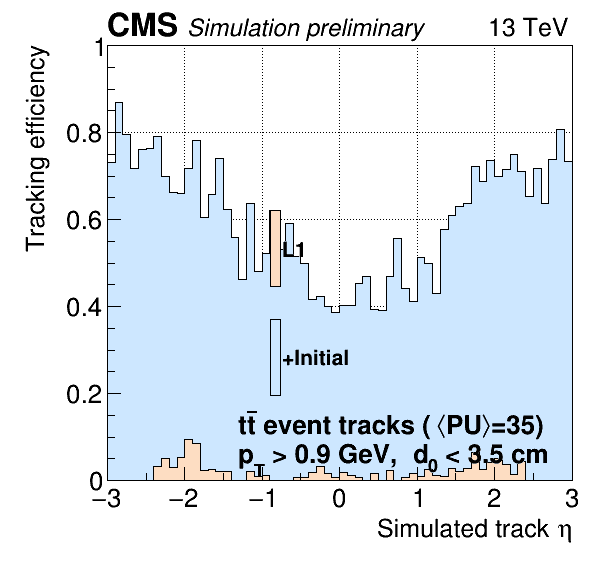

In [14]:
display(Image(filename="ttbar_pu35_phase1_efficiency_eta_cum.png"))


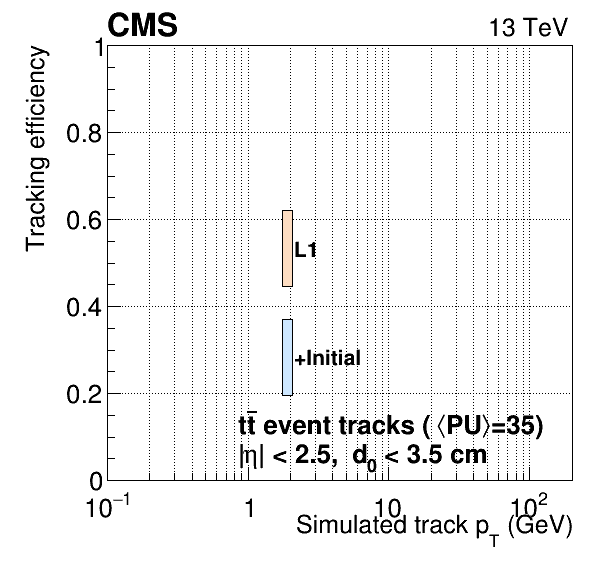

In [116]:
display(Image(filename="ttbar_pu35_phase1_efficiency_pt_cum.png"))

In [46]:
FILENAME = "pix4_l1_recovery.root"

In [47]:
ff = uproot.open(FILENAME)
names = ff['DQMData;1']['Run 1;1']["Tracking"]['Run summary;1']['Track;1'].keys()

names = [f for f in names if "hltPhase2" in f]
interesting = ["ByOriginalAlgo_",]#["General_","L1Step_","InitialStep_"]

names = [ f for f in names if any(ext in f for ext in interesting)]

names
#ff[''].keys()

['hltPhase2CutsRecoInitialStepByOriginalAlgo_hltPhase2ingParticleRecoTrackAsssociation;1',
 'hltPhase2CutsRecoL1StepByOriginalAlgo_hltPhase2ingParticleRecoTrackAsssociation;1']

In [ ]:
FILENAME = "pix4_l1_recovery.root"

ff = uproot.open(FILENAME)
names = ff['DQMData;1']['Run 1;1']["Tracking"]['Run summary;1']['Track;1'].keys()
t
names = [f for f in names if "hltPhase2" in f]
interesting = ["ByOriginalAlgo_","General_"]#["General_","L1Step_","InitialStep_"]

names = [ f for f in names if any(ext in f for ext in interesting)]

names
#ff[''].keys()